# Geospatial Data Format Comparison

A comprehensive comparison of geospatial data storage formats for raster and vector data, focusing on performance, compression, and ease of use.

## Formats Compared

**Raster Formats:**
- GeoTIFF (standard and COG)
- Zarr
- HDF5
- NetCDF

**Vector Formats:**
- GeoJSON
- Parquet / GeoParquet
- FlatGeobuf

## 1. Setup and Imports

In [ ]:
# Install notebook dependencies (run this cell)
%pip install --upgrade \
    geopandas rioxarray rasterio xarray zarr[gpu] cupy h5py netCDF4 pyarrow \
    pandas numpy matplotlib seaborn shapely fiona flatgeobuf zstandard \
    fsspec s3fs rtree h5netcdf scipy


             .',;::::;,'.
         .';:cccccccccccc:;,.
      .;cccccccccccccccccccccc;.
    .:cccccccccccccccccccccccccc:.
  .;ccccccccccccc;.:dddl:.;ccccccc;.
 .:ccccccccccccc;OWMKOOXMWd;ccccccc:.
.:ccccccccccccc;KMMc;cc;xMMc;ccccccc:.
,cccccccccccccc;MMM.;cc;;WW:;cccccccc,
:cccccccccccccc;MMM.;cccccccccccccccc:
:ccccccc;oxOOOo;MMM000k.;cccccccccccc:
cccccc;0MMKxdd:;MMMkddc.;cccccccccccc;
ccccc;XMO';cccc;MMM.;cccccccccccccccc'
ccccc;MMo;ccccc;MMW.;ccccccccccccccc;
ccccc;0MNc.ccc.xMMd;ccccccccccccccc;
cccccc;dNMWXXXWM0:;cccccccccccccc:,
cccccccc;.:odl:.;cccccccccccccc:,.
ccccccccccccccccccccccccccccc:'.
:ccccccccccccccccccccccc:;,..
 ':cccccccccccccccc::;,.akashyap@baymax
---------------
OS: Fedora Linux 43 (WSL) x86_64
Host: Windows Subsystem for Linux - FedoraLinux-43 (2.6.3.0)
Kernel: Linux 6.6.87.2-microsoft-standard-WSL2
Uptime: 2 hours, 41 mins
Packages: 769 (rpm)
Shell: fish 4.2.0
Display (rdp-2): 1920x1080 @ 60 Hz in 24"
Display (rdp-0): 1920x1080 @ 60 Hz
WM: WSLg 1.0.71 (Wayl

In [2]:
import os
import shutil
import tempfile
import time
import warnings
from collections.abc import Callable
from functools import wraps
from pathlib import Path
from typing import Any

import geopandas as gpd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import rioxarray
import seaborn as sns
import xarray as xr
import zarr
from netCDF4 import Dataset as NetCDFDataset
from shapely.geometry import Point, Polygon, box

warnings.filterwarnings("ignore")

# Set plotting style
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100

# Paths
TEST_DATA_DIR = Path("../.test-data")
TEMP_DIR = Path(tempfile.mkdtemp(prefix="geospatial_benchmark_"))

print(f"Test data directory: {TEST_DATA_DIR.resolve()}")
print(f"Temp directory: {TEMP_DIR}")


Test data directory: /home/akashyap/Projects/CoreStack/cs-geodata/.test-data
Temp directory: /tmp/geospatial_benchmark_yxxahqvt


### Benchmarking Utilities

In [3]:
def benchmark(func: Callable, n_runs: int = 3) -> tuple[float, Any]:
    """Run a function multiple times and return average time and result."""
    times = []
    result = None
    for _ in range(n_runs):
        start = time.perf_counter()
        result = func()
        elapsed = time.perf_counter() - start
        times.append(elapsed)
    return np.mean(times), result


def get_file_size_mb(path: Path) -> float:
    """Get file or directory size in MB."""
    if path.is_file():
        return path.stat().st_size / (1024 * 1024)
    elif path.is_dir():
        total = sum(f.stat().st_size for f in path.rglob("*") if f.is_file())
        return total / (1024 * 1024)
    return 0.0


def format_time(seconds: float) -> str:
    """Format time in human-readable format."""
    if seconds < 0.001:
        return f"{seconds * 1000000:.1f} µs"
    elif seconds < 1:
        return f"{seconds * 1000:.1f} ms"
    else:
        return f"{seconds:.2f} s"


def safe_remove(path: Path):
    """Safely remove a file or directory."""
    if path.exists():
        if path.is_dir():
            shutil.rmtree(path)
        else:
            path.unlink()


## 2. Load Test Data from .test-data Directory

In [4]:
# List available test files
print("Available test files:")
for f in TEST_DATA_DIR.iterdir():
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"  - {f.name} ({size_mb:.2f} MB)")


Available test files:
  - jharkhand_godda_sundarpahari_aquifer_vector.geojson (0.98 MB)
  - jharkhand_godda_sundarpahari_natural_depressions_raster.tif (8.00 MB)
  - Microwatershed_boundries_v2.geojson (5490.84 MB)
  - LULC_level_3_LULC_24_25_chitrakoot_mau_level_3.tif (240.00 MB)


In [5]:
# Load raster data from .test-data
RASTER_PATH = (
    TEST_DATA_DIR / "jharkhand_godda_sundarpahari_natural_depressions_raster.tif"
)

raster_da = rioxarray.open_rasterio(RASTER_PATH)
raster_da = raster_da.load()  # Load into memory for fair benchmarking

print(f"Raster file: {RASTER_PATH.name}")
print(f"Shape: {raster_da.shape}")
print(f"CRS: {raster_da.rio.crs}")
print(f"Bounds: {raster_da.rio.bounds()}")
print(f"Data type: {raster_da.dtype}")
print(f"Size in memory: {raster_da.nbytes / 1024 / 1024:.2f} MB")


Raster file: jharkhand_godda_sundarpahari_natural_depressions_raster.tif
Shape: (1, 1664, 991)
CRS: EPSG:4326
Bounds: (87.29549453335433, 24.474959241950017, 87.56256366732306, 24.92339823178248)
Data type: float32
Size in memory: 6.29 MB


In [6]:
# Load vector data from .test-data
VECTOR_PATH = TEST_DATA_DIR / "jharkhand_godda_sundarpahari_aquifer_vector.geojson"

vector_gdf = gpd.read_file(VECTOR_PATH)

print(f"Vector file: {VECTOR_PATH.name}")
print(f"Features: {len(vector_gdf):,}")
print(f"CRS: {vector_gdf.crs}")
print(f"Columns: {list(vector_gdf.columns)}")
print(f"Geometry types: {vector_gdf.geometry.geom_type.unique().tolist()}")
vector_gdf.head()


Vector file: jharkhand_godda_sundarpahari_aquifer_vector.geojson
Features: 175
CRS: EPSG:4326
Columns: ['%_area_aquifer', 'Age', 'Lithology_', 'Major_Aq_1', 'Major_Aqui', 'Principal_', 'Recommende', 'aquifer_class', 'aquifer_count', 'area_in_ha', 'area_re', 'avg_mbgl', 'id', 'intersection_area_ha', 'm2_perday', 'm3_per_day', 'mbgl', 'newcode14', 'newcode43', 'objectid', 'pa_order', 'per_cm', 'state', 'system', 'test', 'uid', 'weighted_contribution', 'y_value', 'yeild__', 'zone_m', 'geometry']
Geometry types: ['MultiPolygon']


,%_area_aquifer,Age,Lithology_,Major_Aq_1,Major_Aqui,Principal_,Recommende,aquifer_class,aquifer_count,area_in_ha,...,per_cm,state,system,test,uid,weighted_contribution,y_value,yeild__,zone_m,geometry
0,9.781722,Azoic to Proterozoic,3,SC01,"Schist - Weathered, Jointed",Schist,7,Hard-Rock,2,2311.235505,...,500-1000,JH,Single,JHSC01,12_322929,0.001467,0.015,Upto 1.5%,10 - 65,"MULTIPOLYGON (((87.37295 24.59691, 87.37271 24..."
1,1.670724,Azoic to Proterozoic,3,SC01,"Schist - Weathered, Jointed",Schist,7,Hard-Rock,4,2626.585318,...,500-1000,JH,Single,JHSC01,12_308282,0.000251,0.015,Upto 1.5%,10 - 65,"MULTIPOLYGON (((87.37784 24.65897, 87.37784 24..."
2,2.975991,Azoic to Proterozoic,3,SC01,"Schist - Weathered, Jointed",Schist,7,Hard-Rock,2,1492.915258,...,500-1000,JH,Single,JHSC01,12_308299,0.000446,0.015,Upto 1.5%,10 - 65,"MULTIPOLYGON (((87.33957 24.74453, 87.33957 24..."
3,1.734903,Azoic to Proterozoic,3,SC01,"Schist - Weathered, Jointed",Schist,7,Hard-Rock,2,3720.284495,...,500-1000,JH,Single,JHSC01,12_309614,0.000260,0.015,Upto 1.5%,10 - 65,"MULTIPOLYGON (((87.34516 24.74135, 87.34469 24..."
4,0.219806,Azoic to Proterozoic,3,SC01,"Schist - Weathered, Jointed",Schist,7,Hard-Rock,5,3057.925667,...,500-1000,JH,Single,JHSC01,12_323259,0.000033,0.015,Upto 1.5%,10 - 65,"MULTIPOLYGON (((87.37353 24.60553, 87.37353 24..."


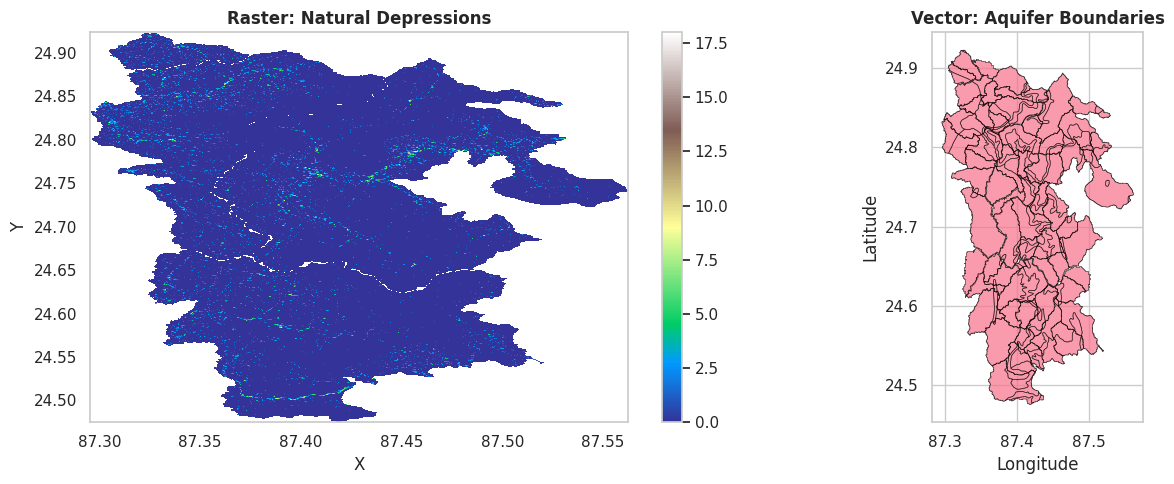

In [7]:
# Visualize the sample data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raster preview
ax = axes[0]
if len(raster_da.shape) == 3:
    raster_da[0].plot(ax=ax, cmap="terrain")
else:
    raster_da.plot(ax=ax, cmap="terrain")
ax.set_title("Raster: Natural Depressions", fontweight="bold")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Vector preview
ax = axes[1]
vector_gdf.plot(ax=ax, edgecolor="black", linewidth=0.5, alpha=0.7)
ax.set_title("Vector: Aquifer Boundaries", fontweight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


---
# Part I: Raster Format Comparison
---

## 3. Raster Write Performance

In [8]:
raster_write_results = {}

# GeoTIFF (uncompressed)
geotiff_path = TEMP_DIR / "raster.tif"
write_time, _ = benchmark(lambda: raster_da.rio.to_raster(str(geotiff_path)))
raster_write_results["GeoTIFF"] = {
    "time": write_time,
    "size": get_file_size_mb(geotiff_path),
}
print(
    f"GeoTIFF: {format_time(write_time)}, {raster_write_results['GeoTIFF']['size']:.2f} MB"
)

# GeoTIFF LZW
geotiff_lzw_path = TEMP_DIR / "raster_lzw.tif"
write_time, _ = benchmark(
    lambda: raster_da.rio.to_raster(str(geotiff_lzw_path), compress="LZW")
)
raster_write_results["GeoTIFF (LZW)"] = {
    "time": write_time,
    "size": get_file_size_mb(geotiff_lzw_path),
}
print(
    f"GeoTIFF LZW: {format_time(write_time)}, {raster_write_results['GeoTIFF (LZW)']['size']:.2f} MB"
)

# GeoTIFF DEFLATE
geotiff_deflate_path = TEMP_DIR / "raster_deflate.tif"
write_time, _ = benchmark(
    lambda: raster_da.rio.to_raster(str(geotiff_deflate_path), compress="DEFLATE")
)
raster_write_results["GeoTIFF (DEFLATE)"] = {
    "time": write_time,
    "size": get_file_size_mb(geotiff_deflate_path),
}
print(
    f"GeoTIFF DEFLATE: {format_time(write_time)}, {raster_write_results['GeoTIFF (DEFLATE)']['size']:.2f} MB"
)


GeoTIFF: 31.5 ms, 8.00 MB
GeoTIFF LZW: 73.4 ms, 0.40 MB
GeoTIFF DEFLATE: 213.2 ms, 0.34 MB


In [9]:
# Zarr (various compressors)
import zarr.codecs

# Convert to xarray DataArray with proper dimensions for zarr
raster_ds = raster_da.to_dataset(name="data")

zarr_path = TEMP_DIR / "raster.zarr"
write_time, _ = benchmark(lambda: raster_ds.to_zarr(zarr_path, mode="w"))
raster_write_results["Zarr (no compression)"] = {
    "time": write_time,
    "size": get_file_size_mb(zarr_path),
}
print(
    f"Zarr: {format_time(write_time)}, {raster_write_results['Zarr (no compression)']['size']:.2f} MB"
)

# Zarr with blosc
zarr_blosc_path = TEMP_DIR / "raster_blosc.zarr"
encoding = {"data": {"compressors": [zarr.codecs.BloscCodec(cname="zstd", clevel=3)]}}
write_time, _ = benchmark(
    lambda: raster_ds.to_zarr(zarr_blosc_path, mode="w", encoding=encoding)
)
raster_write_results["Zarr (blosc-zstd)"] = {
    "time": write_time,
    "size": get_file_size_mb(zarr_blosc_path),
}
print(
    f"Zarr blosc-zstd: {format_time(write_time)}, {raster_write_results['Zarr (blosc-zstd)']['size']:.2f} MB"
)

# Zarr with gzip
zarr_gzip_path = TEMP_DIR / "raster_gzip.zarr"
encoding = {"data": {"compressors": [zarr.codecs.GzipCodec(level=5)]}}
write_time, _ = benchmark(
    lambda: raster_ds.to_zarr(zarr_gzip_path, mode="w", encoding=encoding)
)
raster_write_results["Zarr (gzip)"] = {
    "time": write_time,
    "size": get_file_size_mb(zarr_gzip_path),
}
print(
    f"Zarr gzip: {format_time(write_time)}, {raster_write_results['Zarr (gzip)']['size']:.2f} MB"
)


Zarr: 161.8 ms, 0.38 MB
Zarr blosc-zstd: 77.8 ms, 0.75 MB
Zarr gzip: 99.2 ms, 0.37 MB


In [10]:
# HDF5
h5_path = TEMP_DIR / "raster.h5"


def write_h5():
    with h5py.File(h5_path, "w") as f:
        f.create_dataset("data", data=raster_da.values)
        f.attrs["crs"] = str(raster_da.rio.crs)


write_time, _ = benchmark(write_h5)
raster_write_results["HDF5"] = {"time": write_time, "size": get_file_size_mb(h5_path)}
print(f"HDF5: {format_time(write_time)}, {raster_write_results['HDF5']['size']:.2f} MB")

# HDF5 with gzip
h5_gzip_path = TEMP_DIR / "raster_gzip.h5"


def write_h5_gzip():
    with h5py.File(h5_gzip_path, "w") as f:
        f.create_dataset(
            "data", data=raster_da.values, compression="gzip", compression_opts=5
        )
        f.attrs["crs"] = str(raster_da.rio.crs)


write_time, _ = benchmark(write_h5_gzip)
raster_write_results["HDF5 (gzip)"] = {
    "time": write_time,
    "size": get_file_size_mb(h5_gzip_path),
}
print(
    f"HDF5 gzip: {format_time(write_time)}, {raster_write_results['HDF5 (gzip)']['size']:.2f} MB"
)

# HDF5 with lzf
h5_lzf_path = TEMP_DIR / "raster_lzf.h5"


def write_h5_lzf():
    with h5py.File(h5_lzf_path, "w") as f:
        f.create_dataset("data", data=raster_da.values, compression="lzf")
        f.attrs["crs"] = str(raster_da.rio.crs)


write_time, _ = benchmark(write_h5_lzf)
raster_write_results["HDF5 (lzf)"] = {
    "time": write_time,
    "size": get_file_size_mb(h5_lzf_path),
}
print(
    f"HDF5 lzf: {format_time(write_time)}, {raster_write_results['HDF5 (lzf)']['size']:.2f} MB"
)


HDF5: 38.8 ms, 6.30 MB
HDF5 gzip: 56.2 ms, 0.39 MB
HDF5 lzf: 39.7 ms, 0.64 MB


In [11]:
# NetCDF - Create a clean dataset for NetCDF writing
# Using scipy engine to avoid HDF5 conflicts with h5py
import numpy as np

# Create a minimal, clean dataset for NetCDF benchmarking
data_values = raster_da.values.copy()

# Create new clean dataset from scratch
nc_ds = xr.Dataset(
    {
        "data": (
            ["band", "y", "x"],
            data_values.astype(np.float64),
        )  # scipy needs float64
    },
    coords={
        "band": np.arange(data_values.shape[0]),
        "y": np.arange(data_values.shape[1]).astype(np.float64),
        "x": np.arange(data_values.shape[2]).astype(np.float64),
    },
    attrs={"crs": str(raster_da.rio.crs) if raster_da.rio.crs else "unknown"},
)

nc_path = TEMP_DIR / "raster.nc"


def write_nc():
    safe_remove(nc_path)
    # Use scipy engine (NetCDF3 format) to avoid HDF5 conflicts
    nc_ds.to_netcdf(nc_path, engine="scipy", format="NETCDF3_64BIT")


write_time, _ = benchmark(write_nc)
raster_write_results["NetCDF"] = {"time": write_time, "size": get_file_size_mb(nc_path)}
print(
    f"NetCDF: {format_time(write_time)}, {raster_write_results['NetCDF']['size']:.2f} MB"
)

# NetCDF with compression (using h5netcdf which handles HDF5 differently)
nc_zlib_path = TEMP_DIR / "raster_zlib.nc"


def write_nc_zlib():
    safe_remove(nc_zlib_path)
    # h5netcdf is an alternative to netcdf4 that may handle HDF5 better
    nc_ds.to_netcdf(
        nc_zlib_path,
        engine="h5netcdf",
        encoding={"data": {"compression": "gzip", "compression_opts": 5}},
    )


try:
    write_time, _ = benchmark(write_nc_zlib)
    raster_write_results["NetCDF (zlib)"] = {
        "time": write_time,
        "size": get_file_size_mb(nc_zlib_path),
    }
    print(
        f"NetCDF zlib: {format_time(write_time)}, {raster_write_results['NetCDF (zlib)']['size']:.2f} MB"
    )
except Exception as e:
    print(f"NetCDF zlib skipped due to HDF5 conflict: {e}")
    # Fallback: just copy the uncompressed file size
    raster_write_results["NetCDF (zlib)"] = raster_write_results["NetCDF"].copy()


ModuleNotFoundError: No module named 'scipy'

## 4. Raster Read Performance

In [ ]:
raster_read_results = {}

# GeoTIFF variants
for name, path in [
    ("GeoTIFF", geotiff_path),
    ("GeoTIFF (LZW)", geotiff_lzw_path),
    ("GeoTIFF (DEFLATE)", geotiff_deflate_path),
]:
    read_time, _ = benchmark(lambda p=path: rioxarray.open_rasterio(p).load())
    raster_read_results[name] = read_time
    print(f"{name} read: {format_time(read_time)}")


In [ ]:
# Zarr variants
for name, path in [
    ("Zarr (no compression)", zarr_path),
    ("Zarr (blosc-zstd)", zarr_blosc_path),
    ("Zarr (gzip)", zarr_gzip_path),
]:
    read_time, _ = benchmark(lambda p=path: xr.open_zarr(p).load())
    raster_read_results[name] = read_time
    print(f"{name} read: {format_time(read_time)}")


In [ ]:
# HDF5 variants
for name, path in [
    ("HDF5", h5_path),
    ("HDF5 (gzip)", h5_gzip_path),
    ("HDF5 (lzf)", h5_lzf_path),
]:

    def read_h5(p=path):
        with h5py.File(p, "r") as f:
            return f["data"][:]

    read_time, _ = benchmark(read_h5)
    raster_read_results[name] = read_time
    print(f"{name} read: {format_time(read_time)}")


In [ ]:
# NetCDF variants
for name, path in [("NetCDF", nc_path), ("NetCDF (zlib)", nc_zlib_path)]:
    read_time, _ = benchmark(lambda p=path: xr.open_dataset(p).load())
    raster_read_results[name] = read_time
    print(f"{name} read: {format_time(read_time)}")


## 5. Raster Partial Read (Spatial Subset)

In [ ]:
# Get bounds for subset (center 25% of the raster)
bounds = raster_da.rio.bounds()
x_range = bounds[2] - bounds[0]
y_range = bounds[3] - bounds[1]
subset_bounds = (
    bounds[0] + x_range * 0.375,
    bounds[2] - x_range * 0.375,
    bounds[1] + y_range * 0.375,
    bounds[3] - y_range * 0.375,
)

raster_partial_results = {}


# Zarr - lazy loading with subset
def read_zarr_partial():
    ds = xr.open_zarr(zarr_blosc_path)
    return ds["data"].isel(x=slice(100, 200), y=slice(100, 200)).load()


read_time, _ = benchmark(read_zarr_partial)
raster_partial_results["Zarr (blosc-zstd)"] = read_time
print(f"Zarr partial read: {format_time(read_time)}")


# NetCDF - lazy loading with subset
def read_nc_partial():
    ds = xr.open_dataset(nc_zlib_path)
    return ds["data"].isel(x=slice(100, 200), y=slice(100, 200)).load()


read_time, _ = benchmark(read_nc_partial)
raster_partial_results["NetCDF (zlib)"] = read_time
print(f"NetCDF partial read: {format_time(read_time)}")


# HDF5 - manual slicing
def read_h5_partial():
    with h5py.File(h5_gzip_path, "r") as f:
        data = f["data"]
        if len(data.shape) == 3:
            return data[:, 100:200, 100:200]
        else:
            return data[100:200, 100:200]


read_time, _ = benchmark(read_h5_partial)
raster_partial_results["HDF5 (gzip)"] = read_time
print(f"HDF5 partial read: {format_time(read_time)}")


## 6. Raster Format Visualizations

In [ ]:
# Create comparison dataframes
raster_df = pd.DataFrame(
    [
        {
            "Format": k,
            "Write Time (s)": v["time"],
            "Size (MB)": v["size"],
            "Read Time (s)": raster_read_results.get(k, np.nan),
        }
        for k, v in raster_write_results.items()
    ]
)
raster_df["Compression Ratio"] = raster_df["Size (MB)"].max() / raster_df["Size (MB)"]
raster_df = raster_df.sort_values("Size (MB)")
raster_df


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# File Size Comparison
ax = axes[0, 0]
colors = sns.color_palette("husl", len(raster_df))
bars = ax.barh(raster_df["Format"], raster_df["Size (MB)"], color=colors)
ax.set_xlabel("Size (MB)")
ax.set_title("Raster File Size Comparison", fontsize=12, fontweight="bold")
ax.bar_label(bars, fmt="%.1f MB", padding=3)

# Write Time Comparison
ax = axes[0, 1]
bars = ax.barh(raster_df["Format"], raster_df["Write Time (s)"] * 1000, color=colors)
ax.set_xlabel("Write Time (ms)")
ax.set_title("Raster Write Performance", fontsize=12, fontweight="bold")
ax.bar_label(bars, fmt="%.0f ms", padding=3)

# Read Time Comparison
ax = axes[1, 0]
bars = ax.barh(raster_df["Format"], raster_df["Read Time (s)"] * 1000, color=colors)
ax.set_xlabel("Read Time (ms)")
ax.set_title("Raster Read Performance", fontsize=12, fontweight="bold")
ax.bar_label(bars, fmt="%.0f ms", padding=3)

# Compression Ratio vs Write Time (Trade-off)
ax = axes[1, 1]
scatter = ax.scatter(
    raster_df["Write Time (s)"] * 1000,
    raster_df["Compression Ratio"],
    s=100,
    c=range(len(raster_df)),
    cmap="husl",
    edgecolors="black",
    linewidth=1,
)
for i, row in raster_df.iterrows():
    ax.annotate(
        row["Format"],
        (row["Write Time (s)"] * 1000, row["Compression Ratio"]),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=8,
    )
ax.set_xlabel("Write Time (ms)")
ax.set_ylabel("Compression Ratio")
ax.set_title("Compression vs Speed Trade-off", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig(TEMP_DIR / "raster_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


---
# Part II: Vector Format Comparison
---

## 7. Vector Write Performance

In [ ]:
vector_write_results = {}

# GeoJSON
geojson_path = TEMP_DIR / "vector.geojson"
write_time, _ = benchmark(lambda: vector_gdf.to_file(geojson_path, driver="GeoJSON"))
vector_write_results["GeoJSON"] = {
    "time": write_time,
    "size": get_file_size_mb(geojson_path),
}
print(
    f"GeoJSON: {format_time(write_time)}, {vector_write_results['GeoJSON']['size']:.2f} MB"
)


In [ ]:
# Parquet (various compression)
parquet_path = TEMP_DIR / "vector.parquet"
write_time, _ = benchmark(lambda: vector_gdf.to_parquet(parquet_path))
vector_write_results["Parquet (snappy)"] = {
    "time": write_time,
    "size": get_file_size_mb(parquet_path),
}
print(
    f"Parquet snappy: {format_time(write_time)}, {vector_write_results['Parquet (snappy)']['size']:.2f} MB"
)

parquet_gzip_path = TEMP_DIR / "vector_gzip.parquet"
write_time, _ = benchmark(
    lambda: vector_gdf.to_parquet(parquet_gzip_path, compression="gzip")
)
vector_write_results["Parquet (gzip)"] = {
    "time": write_time,
    "size": get_file_size_mb(parquet_gzip_path),
}
print(
    f"Parquet gzip: {format_time(write_time)}, {vector_write_results['Parquet (gzip)']['size']:.2f} MB"
)

parquet_zstd_path = TEMP_DIR / "vector_zstd.parquet"
write_time, _ = benchmark(
    lambda: vector_gdf.to_parquet(parquet_zstd_path, compression="zstd")
)
vector_write_results["Parquet (zstd)"] = {
    "time": write_time,
    "size": get_file_size_mb(parquet_zstd_path),
}
print(
    f"Parquet zstd: {format_time(write_time)}, {vector_write_results['Parquet (zstd)']['size']:.2f} MB"
)


In [ ]:
# FlatGeobuf
fgb_path = TEMP_DIR / "vector.fgb"
write_time, _ = benchmark(lambda: vector_gdf.to_file(fgb_path, driver="FlatGeobuf"))
vector_write_results["FlatGeobuf"] = {
    "time": write_time,
    "size": get_file_size_mb(fgb_path),
}
print(
    f"FlatGeobuf: {format_time(write_time)}, {vector_write_results['FlatGeobuf']['size']:.2f} MB"
)


## 8. Vector Read Performance

In [ ]:
vector_read_results = {}

# GeoJSON
read_time, _ = benchmark(lambda: gpd.read_file(geojson_path))
vector_read_results["GeoJSON"] = read_time
print(f"GeoJSON read: {format_time(read_time)}")

# Parquet variants
for name, path in [
    ("Parquet (snappy)", parquet_path),
    ("Parquet (gzip)", parquet_gzip_path),
    ("Parquet (zstd)", parquet_zstd_path),
]:
    read_time, _ = benchmark(lambda p=path: gpd.read_parquet(p))
    vector_read_results[name] = read_time
    print(f"{name} read: {format_time(read_time)}")

# FlatGeobuf
read_time, _ = benchmark(lambda: gpd.read_file(fgb_path))
vector_read_results["FlatGeobuf"] = read_time
print(f"FlatGeobuf read: {format_time(read_time)}")


## 9. Vector Column-Selective Read

In [ ]:
# Parquet column selection (only read specific columns)
available_cols = [c for c in vector_gdf.columns if c != "geometry"][:3] + ["geometry"]
print(f"Testing column-selective read with columns: {available_cols}")

full_read_time, _ = benchmark(lambda: gpd.read_parquet(parquet_zstd_path))
selective_read_time, _ = benchmark(
    lambda: gpd.read_parquet(parquet_zstd_path, columns=available_cols)
)

print(f"Full read (all columns): {format_time(full_read_time)}")
print(
    f"Selective read ({len(available_cols)} columns): {format_time(selective_read_time)}"
)
print(f"Speedup: {full_read_time / selective_read_time:.2f}x")


## 10. Vector Attribute Filtering

In [ ]:
# Find a suitable column for filtering
filter_col = None
filter_val = None
for col in vector_gdf.columns:
    if col != "geometry" and vector_gdf[col].dtype == "object":
        unique_vals = vector_gdf[col].dropna().unique()
        if len(unique_vals) > 1:
            filter_col = col
            filter_val = unique_vals[0]
            break

if filter_col:
    print(f"Filtering on column '{filter_col}' with value '{filter_val}'")

    vector_filter_results = {}

    # GeoJSON - must load all then filter
    filter_time, _ = benchmark(
        lambda: gpd.read_file(geojson_path).query(f"`{filter_col}` == @filter_val")
    )
    vector_filter_results["GeoJSON"] = filter_time
    print(f"GeoJSON filter: {format_time(filter_time)}")

    # Parquet - can use row group filtering with pyarrow
    filter_time, _ = benchmark(
        lambda: gpd.read_parquet(
            parquet_zstd_path, filters=[(filter_col, "==", filter_val)]
        )
    )
    vector_filter_results["Parquet (zstd)"] = filter_time
    print(f"Parquet filter: {format_time(filter_time)}")

    # FlatGeobuf
    filter_time, _ = benchmark(
        lambda: gpd.read_file(fgb_path).query(f"`{filter_col}` == @filter_val")
    )
    vector_filter_results["FlatGeobuf"] = filter_time
    print(f"FlatGeobuf filter: {format_time(filter_time)}")
else:
    print("No suitable categorical column found for filtering test.")
    vector_filter_results = {}


## 11. Vector Format Visualizations

In [ ]:
# Create comparison dataframe
vector_df = pd.DataFrame(
    [
        {
            "Format": k,
            "Write Time (s)": v["time"],
            "Size (MB)": v["size"],
            "Read Time (s)": vector_read_results.get(k, np.nan),
        }
        for k, v in vector_write_results.items()
    ]
)
vector_df["Compression Ratio"] = vector_df["Size (MB)"].max() / vector_df["Size (MB)"]
vector_df = vector_df.sort_values("Size (MB)")
vector_df


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = sns.color_palette("Set2", len(vector_df))

# File Size
ax = axes[0, 0]
bars = ax.barh(vector_df["Format"], vector_df["Size (MB)"], color=colors)
ax.set_xlabel("Size (MB)")
ax.set_title("Vector File Size Comparison", fontsize=12, fontweight="bold")
ax.bar_label(bars, fmt="%.2f MB", padding=3)

# Write Time
ax = axes[0, 1]
bars = ax.barh(vector_df["Format"], vector_df["Write Time (s)"] * 1000, color=colors)
ax.set_xlabel("Write Time (ms)")
ax.set_title("Vector Write Performance", fontsize=12, fontweight="bold")
ax.bar_label(bars, fmt="%.0f ms", padding=3)

# Read Time
ax = axes[1, 0]
bars = ax.barh(vector_df["Format"], vector_df["Read Time (s)"] * 1000, color=colors)
ax.set_xlabel("Read Time (ms)")
ax.set_title("Vector Read Performance", fontsize=12, fontweight="bold")
ax.bar_label(bars, fmt="%.0f ms", padding=3)

# Filter Performance (if available)
ax = axes[1, 1]
if vector_filter_results:
    filter_df = pd.DataFrame(
        {
            "Format": list(vector_filter_results.keys()),
            "Filter Time (ms)": [v * 1000 for v in vector_filter_results.values()],
        }
    )
    bars = ax.barh(
        filter_df["Format"],
        filter_df["Filter Time (ms)"],
        color=colors[: len(filter_df)],
    )
    ax.set_xlabel("Filter Time (ms)")
    ax.set_title("Attribute Filtering Performance", fontsize=12, fontweight="bold")
    ax.bar_label(bars, fmt="%.0f ms", padding=3)
else:
    ax.text(
        0.5,
        0.5,
        "No filtering test\n(no suitable column)",
        ha="center",
        va="center",
        transform=ax.transAxes,
    )
    ax.set_title("Attribute Filtering Performance", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig(TEMP_DIR / "vector_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


---
# Part III: Summary & Recommendations
---

## 12. Ease of Use & Support Analysis

In [ ]:
# Qualitative ratings (1-5 scale)
ease_of_use = pd.DataFrame(
    {
        "Format": [
            "GeoTIFF",
            "Zarr",
            "HDF5",
            "NetCDF",
            "GeoJSON",
            "Parquet",
            "FlatGeobuf",
        ],
        "API Simplicity": [5, 4, 3, 4, 5, 4, 4],
        "Documentation": [5, 4, 4, 5, 5, 4, 3],
        "Python Support": [5, 5, 5, 5, 5, 5, 4],
        "Cloud-Native": [3, 5, 3, 3, 2, 5, 3],
        "Industry Adoption": [5, 4, 5, 5, 5, 4, 3],
        "Parallel I/O": [2, 5, 4, 4, 1, 5, 2],
    }
)

ease_of_use["Overall Score"] = ease_of_use.iloc[:, 1:].mean(axis=1).round(1)
ease_of_use = ease_of_use.sort_values("Overall Score", ascending=False)
ease_of_use


In [ ]:
# Radar chart for format comparison
from math import pi

categories = [
    "API Simplicity",
    "Documentation",
    "Python Support",
    "Cloud-Native",
    "Industry Adoption",
    "Parallel I/O",
]
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = sns.color_palette("husl", len(ease_of_use))

for idx, row in ease_of_use.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        label=row["Format"],
        color=colors[list(ease_of_use.index).index(idx)],
    )
    ax.fill(angles, values, alpha=0.1, color=colors[list(ease_of_use.index).index(idx)])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 5)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))
ax.set_title("Format Comparison Radar Chart", fontsize=14, fontweight="bold", y=1.08)

plt.tight_layout()
plt.savefig(TEMP_DIR / "radar_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


## 13. Format Selection Decision Guide

In [ ]:
decision_guide = pd.DataFrame(
    {
        "Use Case": [
            "Simple raster sharing",
            "Cloud-optimized rasters",
            "Large array analytics",
            "Scientific datasets",
            "Climate/Weather data",
            "Web mapping",
            "Vector analytics",
            "Streaming vector data",
        ],
        "Recommended Format": [
            "GeoTIFF (LZW)",
            "COG or Zarr",
            "Zarr (blosc)",
            "HDF5/NetCDF",
            "NetCDF (CF conventions)",
            "GeoJSON or FlatGeobuf",
            "Parquet (zstd)",
            "FlatGeobuf",
        ],
        "Why": [
            "Universal support, good compression",
            "HTTP range requests, tiled access",
            "Parallel I/O, chunked storage",
            "Complex hierarchies, rich metadata",
            "Standard conventions, tool support",
            "Browser-native, simple features",
            "Column projection, fast filtering",
            "Spatial index, streaming support",
        ],
    }
)

decision_guide.style.set_properties(**{"text-align": "left"}).set_table_styles(
    [{"selector": "th", "props": [("text-align", "left")]}]
)


## 14. Final Summary

In [ ]:
print("=" * 60)
print("GEOSPATIAL FORMAT COMPARISON SUMMARY")
print("=" * 60)

print(f"\n📁 TEST DATA USED")
print("-" * 40)
print(f"Raster: {RASTER_PATH.name}")
print(f"Vector: {VECTOR_PATH.name}")

print("\n📊 RASTER FORMATS")
print("-" * 40)
best_raster_size = raster_df.loc[raster_df["Size (MB)"].idxmin()]
best_raster_read = raster_df.loc[raster_df["Read Time (s)"].idxmin()]
best_raster_write = raster_df.loc[raster_df["Write Time (s)"].idxmin()]

print(
    f"Best Compression: {best_raster_size['Format']} ({best_raster_size['Size (MB)']:.2f} MB)"
)
print(
    f"Fastest Read: {best_raster_read['Format']} ({format_time(best_raster_read['Read Time (s)'])})"
)
print(
    f"Fastest Write: {best_raster_write['Format']} ({format_time(best_raster_write['Write Time (s)'])})"
)

print("\n📍 VECTOR FORMATS")
print("-" * 40)
best_vector_size = vector_df.loc[vector_df["Size (MB)"].idxmin()]
best_vector_read = vector_df.loc[vector_df["Read Time (s)"].idxmin()]
best_vector_write = vector_df.loc[vector_df["Write Time (s)"].idxmin()]

print(
    f"Best Compression: {best_vector_size['Format']} ({best_vector_size['Size (MB)']:.2f} MB)"
)
print(
    f"Fastest Read: {best_vector_read['Format']} ({format_time(best_vector_read['Read Time (s)'])})"
)
print(
    f"Fastest Write: {best_vector_write['Format']} ({format_time(best_vector_write['Write Time (s)'])})"
)

print("\n🎯 KEY TAKEAWAYS")
print("-" * 40)
print("• Zarr excels for cloud-native raster workloads with parallel I/O")
print("• Parquet offers best vector analytics performance with column pruning")
print("• GeoTIFF remains the universal interchange format for rasters")
print("• HDF5/NetCDF are ideal for scientific multi-dimensional data")
print("• FlatGeobuf provides good balance of size and streaming capability")


In [ ]:
# Cleanup temp directory
print(f"\nTemp files location: {TEMP_DIR}")
print("Run the following to cleanup:")
print(f"  shutil.rmtree('{TEMP_DIR}')")


## 15. Experiments with GPU - ZARR


In [ ]:
import cupy as cp

zarr.config.enable_gpu()
zarr_gpu_path = TEMP_DIR / "raster_gpu.zarr"


### Write Operations